In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# configuration
# grid resolution
TIME_BIN_SIZE_MIN = 5
DISTANCE_BIN_COUNT = 160

# file paths
STATION_MAP_FILE = "../data/a_line_station_distances.csv"
SCHEDULE_FILE = "../data/target_terminal_headways.csv"
REALTIME_ARRIVALS_FILE = "../data/nyc_subway_a_line_arrivals_2025.csv"

In [2]:
# load the datsets
print("Loading Datasets...")

# 1. static station map (space)
station_map = pd.read_csv(STATION_MAP_FILE)
print(f"Loaded {len(station_map)} stations (Total).")

# FILTER: Keep only Northbound stations to avoid Directional Collision
station_map = station_map[station_map['stop_id'].str.endswith('N')]
print(f"Filtered to {len(station_map)} Northbound stations.")

# 2. target schedule (intent)
schedule_df = pd.read_csv(SCHEDULE_FILE)
print(f"Loaded {len(schedule_df)} scheduled departures.")

# 3 real time arrivals (reality)
arrivals_df = pd.read_csv(REALTIME_ARRIVALS_FILE)

# ensure timestamps are datetime objects
arrivals_df['arrival_time'] = pd.to_datetime(arrivals_df['arrival_time'])

print(f"Loaded {len(arrivals_df)} real-time arrival records.")

# preview
display(station_map.head())
display(arrivals_df.head())

Loading Datasets...
Loaded 156 stations (Total).
Filtered to 52 Northbound stations.
Loaded 31480 scheduled departures.
Loaded 2100859 real-time arrival records.


,stop_id,stop_name,distance_from_start_mi,location_type,parent_station
1,A65N,Ozone Park-Lefferts Blvd,9.466588,0,A65
4,A63N,104 St,9.481178,0,A63
7,A64N,111 St,9.481178,0,A64
10,A61N,Rockaway Blvd,9.686007,0,A61
13,A60N,88 St,10.088497,0,A60


,trip_uid,route_id,direction,stop_id,stop_name,stop_lat,stop_lon,arrival_time
0,1749151110_A..S57R,A,S,A38S,Fulton St,40.710197,-74.007691,2025-06-06 00:00:00+00:00
1,1749153120_A..N55R,A,N,H06N,Beach 67 St,40.590927,-73.796924,2025-06-06 00:00:02+00:00
2,1749149220_A..S58R,A,S,H03S,Howard Beach-JFK Airport,40.660476,-73.830301,2025-06-06 00:00:07+00:00
3,1749153300_A..S57R,A,S,A06S,181 St,40.851695,-73.937969,2025-06-06 00:00:17+00:00
4,1749147750_A..S58R,A,S,H11S,Far Rockaway-Mott Av,40.603995,-73.755405,2025-06-06 00:00:23+00:00


In [3]:
# Create the Distance Grid (Space Dimension)

# We need to map every stop_id to a bin index (0 to 159)
# Formula: bin = floor( (distance - min_dist) / bin_width )

min_dist = station_map['distance_from_start_mi'].min()
max_dist = station_map['distance_from_start_mi'].max()

# Calculate bin width
total_length = max_dist - min_dist
bin_width = total_length / DISTANCE_BIN_COUNT

print(f"Line Length: {total_length:.2f} miles")
print(f"Bin Width: {bin_width:.2f} miles")

def get_distance_bin(dist_val):
    if pd.isna(dist_val): return -1
    # The formula from our requirements doc
    bin_idx = int((dist_val - min_dist) / bin_width)
    # Clamp to max bin index (handle edge case at exact max distance)
    return min(bin_idx, DISTANCE_BIN_COUNT - 1)

# Apply to station map
station_map['distance_bin'] = station_map['distance_from_start_mi'].apply(get_distance_bin)

# Create a lookup dictionary for fast mapping later
# Key: stop_id, Value: distance_bin
stop_to_bin_map = station_map.set_index('stop_id')['distance_bin'].to_dict()

# Show the map
display(station_map[['stop_id', 'stop_name', 'distance_from_start_mi', 'distance_bin']].head(10))

Line Length: 22.73 miles
Bin Width: 0.14 miles


,stop_id,stop_name,distance_from_start_mi,distance_bin
1,A65N,Ozone Park-Lefferts Blvd,9.466588,0
4,A63N,104 St,9.481178,0
7,A64N,111 St,9.481178,0
10,A61N,Rockaway Blvd,9.686007,1
13,A60N,88 St,10.088497,4
16,A59N,80 St,10.484866,7
19,A57N,Grant Av,10.853113,9
23,A55N,Euclid Av,11.249591,12
25,A54N,Shepherd Av,11.711652,15
28,A53N,Van Siclen Av,12.225694,19


In [4]:
# create the time grid bins (time dimension)

# define the global start time for the entire experiment
# this must match the start of our data collection
# Ensure it is tz-naive to match the arrivals data
GLOBAL_START_TIME = pd.Timestamp("2025-06-06 00:00:00")

def get_time_bin(timestamp):
    # Ensure timestamp is tz-naive before subtraction
    if timestamp.tzinfo is not None:
        timestamp = timestamp.tz_localize(None)
        
    #calculate minutes elapsed since the global start
    delta = timestamp - GLOBAL_START_TIME   
    minutes_elapsed = delta.total_seconds() / 60.0

    # floor division by bin size
    return int(minutes_elapsed // TIME_BIN_SIZE_MIN)

# apply to arrivals
arrivals_df['time_bin'] = arrivals_df['arrival_time'].apply(get_time_bin)

# apply to schedule (we need to construct full timestamps for the schedule first)
# the schedule has 'service_date' (2025-01-01) and departure seconds (28000)
# we combine to get a timestamp, then bin it.
schedule_df['full_timestamp'] = pd.to_datetime(schedule_df['service_date']) + \
                                pd.to_timedelta(schedule_df['departure_seconds'], unit='s')

schedule_df['time_bin'] = schedule_df['full_timestamp'].apply(get_time_bin)

print('Time binning complete')
display(arrivals_df[['arrival_time','time_bin']].head())
display(schedule_df[['full_timestamp','time_bin']].head())

Time binning complete


,arrival_time,time_bin
0,2025-06-06 00:00:00+00:00,0
1,2025-06-06 00:00:02+00:00,0
2,2025-06-06 00:00:07+00:00,0
3,2025-06-06 00:00:17+00:00,0
4,2025-06-06 00:00:23+00:00,0


,full_timestamp,time_bin
0,2025-01-01 00:39:30,-44921
1,2025-01-01 00:59:30,-44917
2,2025-01-01 01:19:30,-44913
3,2025-01-01 01:39:30,-44909
4,2025-01-01 01:59:30,-44905


In [5]:
# map real-time arrivals to distance bins

# use the disctionary we created earlier
arrivals_df['distance_bin'] = arrivals_df['stop_id'].map(stop_to_bin_map)

# drop arrivals that dont map to a known station (e.g. maintenance stops)
intial_count = len(arrivals_df)
arrivals_df = arrivals_df.dropna(subset=['distance_bin'])
arrivals_df['distance_bin'] = arrivals_df['distance_bin'].astype(int)
final_count = len(arrivals_df)

print(f"Mapped {final_count} arrivals to distance bins.")
print(f"Dropped {intial_count - final_count} records (unknown stops).")

display(arrivals_df.head())

Mapped 900988 arrivals to distance bins.
Dropped 1199871 records (unknown stops).


,trip_uid,route_id,direction,stop_id,stop_name,stop_lat,stop_lon,arrival_time,time_bin,distance_bin
7,1749150120_A..N54R,A,N,A15N,125 St,40.811109,-73.952343,2025-06-06 00:00:30+00:00,0,128
9,1749152880_A..N54R,A,N,A57N,Grant Av,40.677044,-73.865050,2025-06-06 00:00:57+00:00,0,9
11,1749151080_A..N54R,A,N,A28N,34 St-Penn Station,40.752287,-73.993391,2025-06-06 00:01:17+00:00,0,95
12,1749151980_A..N54R,A,N,A41N,Jay St-MetroTech,40.692338,-73.987342,2025-06-06 00:01:17+00:00,0,59
15,1749150240_A..N55R,A,N,A42N,Hoyt-Schermerhorn Sts,40.688484,-73.985001,2025-06-06 00:01:47+00:00,0,57


headway calculation complete


,arrival_time,stop_id,headway_min
108,2025-06-06 00:11:59+00:00,A02N,8.400000
165,2025-06-06 00:18:30+00:00,A02N,6.516667
268,2025-06-06 00:28:59+00:00,A02N,10.483333
330,2025-06-06 00:36:47+00:00,A02N,7.800000
447,2025-06-06 00:49:59+00:00,A02N,13.200000
470,2025-06-06 00:52:32+00:00,A02N,2.550000
548,2025-06-06 01:02:47+00:00,A02N,10.250000
613,2025-06-06 01:10:23+00:00,A02N,7.600000
705,2025-06-06 01:21:35+00:00,A02N,11.200000
760,2025-06-06 01:28:37+00:00,A02N,7.033333


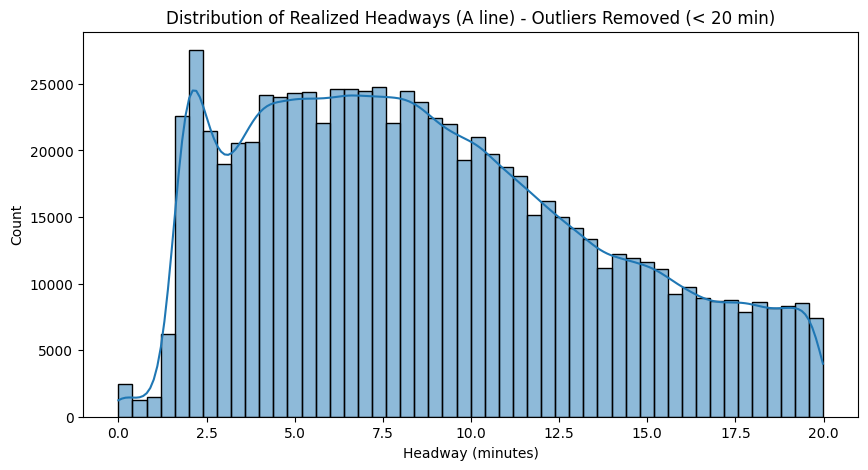

In [6]:
# calculate realized headways
# calculates the actual time gap between trains at each station

# 1. sort by station and time
# we need to ensure trains are in order to calculate the gap between them
arrivals_df = arrivals_df.sort_values(['stop_id', 'arrival_time'])

# 2. calculate delta (time since last train at this station)
# we group by 'stop_id' so we don't calculate headway between two different stations
arrivals_df['prev_arrival_time'] = arrivals_df.groupby('stop_id')['arrival_time'].shift(1)
arrivals_df['headway_min'] = (arrivals_df['arrival_time'] - arrivals_df['prev_arrival_time']).dt.total_seconds() / 60.0

# 3 filter invalid headways
# - drop the first train of the day (nan headway)
arrivals_df = arrivals_df.dropna(subset=['headway_min'])

# --- REPAIR STRATEGY: Outlier Removal ---
# We treat headways > 20 minutes as "Missing Data" or "Non-Standard Service".
# ANALYSIS: Many of the 20-30 min gaps occur at Local stops (e.g., 116 St, 23 St) where the 
# Express 'A' train rarely stops during rush hour. These are not true service gaps, but rather 
# artifacts of the train skipping stops.
# By filtering them out, we allow the spatial interpolation to estimate the flow based on 
# the Express stops (where data is frequent and reliable).
arrivals_df = arrivals_df[arrivals_df['headway_min'] < 20]

print("headway calculation complete")
display(arrivals_df[['arrival_time', 'stop_id', 'headway_min']].head(10))

# visualize the distribution of realized headways
plt.figure(figsize=(10,5))
sns.histplot(arrivals_df['headway_min'], bins=50, kde=True)
plt.title("Distribution of Realized Headways (A line) - Outliers Removed (< 20 min)")
plt.xlabel("Headway (minutes)")
plt.show()

Matrix Dimensions: 52834 Time Bins x 160 Distance Bins
Date Range: 2025-06-06 00:00:00 to 2025-12-06 10:45:00
Sparse matrix created
First data appears at time bin: 0


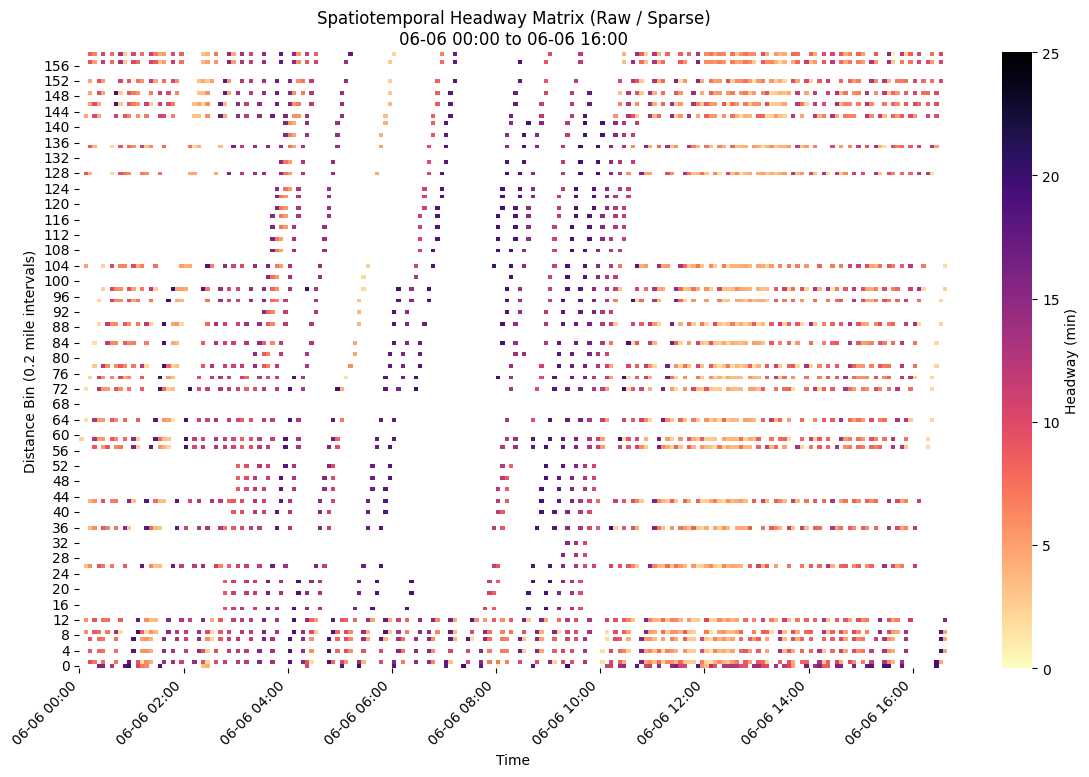

In [7]:
# create the spatiotemporal matrix

# Filter out any data before the global start time (negative bins)
# This ensures we don't index negatively into the matrix
arrivals_df = arrivals_df[arrivals_df['time_bin'] >= 0]

# 1 define matrix dimensions
max_time_bin = arrivals_df['time_bin'].max()

# we add 1 because bins are 0-indexed
total_time_bins = max_time_bin + 1

print(f"Matrix Dimensions: {total_time_bins} Time Bins x {DISTANCE_BIN_COUNT} Distance Bins")
print(f"Date Range: {GLOBAL_START_TIME} to {GLOBAL_START_TIME + pd.Timedelta(minutes=max_time_bin*TIME_BIN_SIZE_MIN)}")

# 2 initialize empty matrix (filled with nans)
# we use nans to distinguish missing data from 0 headway
grid_matrix = np.full((total_time_bins, DISTANCE_BIN_COUNT), np.nan)

# 3 populate matrix with realized headways
# we iterate through our dataframe and place values int the grid
# note if multiple trains fall into the same bin (rare) we take the mean
grouped = arrivals_df.groupby(['time_bin', 'distance_bin'])['headway_min'].mean()

for (t_bin, d_bin), headway in grouped.items():
    if t_bin < total_time_bins and d_bin < DISTANCE_BIN_COUNT:
        grid_matrix[t_bin, d_bin] = headway

print("Sparse matrix created")

# find the first time bin that actually has data
valid_indices = np.where(~np.isnan(grid_matrix).all(axis=1))[0]
if len(valid_indices) > 0:
    first_valid_idx = valid_indices[0]
    print(f"First data appears at time bin: {first_valid_idx}")
else:
    first_valid_idx = 0
    print("Warning: Matrix is empty!")

# visualize a slice starting from where the data actually begins
start_plot = first_valid_idx
end_plot = min(first_valid_idx + 200, total_time_bins)

plt.figure(figsize=(14, 8))
# Using 'magma_r' (reversed magma) provides high contrast and is perceptually uniform.
ax = sns.heatmap(grid_matrix[start_plot:end_plot, :].T, cmap="magma_r", vmin=0, vmax=25, cbar_kws={'label': 'Headway (min)'})

# --- Create Time Labels ---
# Calculate how many bins we are plotting
n_bins = end_plot - start_plot
# We want a tick every 2 hours (120 mins / 5 min bin = 24 bins)
tick_interval = 24
tick_positions = np.arange(0, n_bins, tick_interval)
# Calculate the actual timestamp for each tick position
tick_labels = [
    (GLOBAL_START_TIME + pd.Timedelta(minutes=int(start_plot + i) * TIME_BIN_SIZE_MIN)).strftime('%m-%d %H:%M')
    for i in tick_positions
]

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45, ha='right')
# --------------------------

plt.title(f"Spatiotemporal Headway Matrix (Raw / Sparse)\n{tick_labels[0]} to {tick_labels[-1]}")
plt.xlabel("Time")
plt.ylabel("Distance Bin (0.2 mile intervals)")
plt.gca().invert_yaxis()
plt.show()

Interpolation complete.


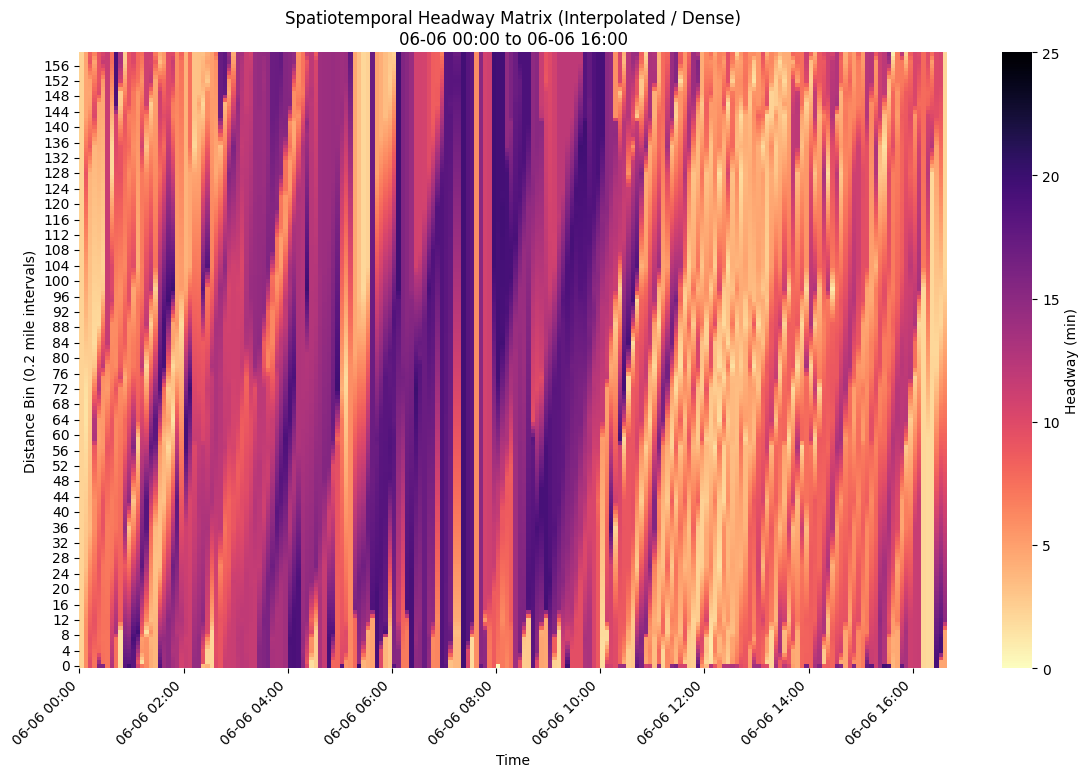

In [8]:
# interpolate missing values (repairing the grid)

# convert to dataframe for easy interpolation
grid_df = pd.DataFrame(grid_matrix)

# 1. Interpolate along the distance axis (axis=1)
# We limit the direction to avoid extrapolating at the ends of the line if no data exists
grid_interpolated = grid_df.interpolate(method="linear", axis=1, limit_direction='both')

# 2. Fill remaining nans (e.g. edges) with forward/backward fill along time axis
# Caution: This propagates data across time gaps. 
grid_interpolated = grid_interpolated.ffill(axis=0).bfill(axis=0)

# convert back to numpy array
final_matrix = grid_interpolated.values

print("Interpolation complete.")

# visualize the same slice after interpolation
plt.figure(figsize=(14,8))
# Using 'magma_r' for consistency. 
ax = sns.heatmap(final_matrix[start_plot:end_plot, :].T, cmap="magma_r", vmin=0, vmax=25, cbar_kws={"label": "Headway (min)"})

# --- Create Time Labels ---
# Reuse the same tick logic from the previous cell since start_plot/end_plot are the same
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45, ha='right')
# --------------------------

plt.title(f"Spatiotemporal Headway Matrix (Interpolated / Dense)\n{tick_labels[0]} to {tick_labels[-1]}")
plt.xlabel("Time")
plt.ylabel("Distance Bin (0.2 mile intervals)")
plt.gca().invert_yaxis()
plt.show()

In [9]:
# save the final grid
output_path = "../data/headway_matrix_full.npy"
np.save(output_path, final_matrix)

print(f"Saved final matrix to {output_path}")
print(f"Shape: {final_matrix.shape}")

Saved final matrix to ../data/headway_matrix_full.npy
Shape: (52834, 160)


In [10]:
# --- DIAGNOSTIC: Investigate "Black Holes" ---
# This cell helps verify if high headways are real delays or missing data.

# 1. Define the window shown in the plot above
# Ensure plot_start_time and plot_end_time are timezone-aware (UTC) to match arrivals_df
plot_start_time = GLOBAL_START_TIME + pd.Timedelta(minutes=start_plot * TIME_BIN_SIZE_MIN)
plot_end_time = GLOBAL_START_TIME + pd.Timedelta(minutes=end_plot * TIME_BIN_SIZE_MIN)

# If arrivals_df is timezone-aware (UTC), we must localize our comparison timestamps
if arrivals_df['arrival_time'].dt.tz is not None:
    if plot_start_time.tzinfo is None:
        plot_start_time = plot_start_time.tz_localize('UTC')
    if plot_end_time.tzinfo is None:
        plot_end_time = plot_end_time.tz_localize('UTC')

print(f"Investigating window: {plot_start_time} to {plot_end_time}")

# 2. Filter for long headways (> 20 mins) during Peak Hours (6 AM - 10 AM)
# We focus on peak hours because 20 min headways are normal at 3 AM, but suspicious at 8 AM.
window_df = arrivals_df[
    (arrivals_df['arrival_time'] >= plot_start_time) & 
    (arrivals_df['arrival_time'] <= plot_end_time)
].copy()

# Filter for Peak Hours (approximate)
peak_df = window_df[window_df['arrival_time'].dt.hour.between(6, 10)]
suspicious_gaps = peak_df[peak_df['headway_min'] > 20].sort_values('headway_min', ascending=False)

print(f"Found {len(suspicious_gaps)} suspicious gaps (>20 min) during AM Peak (06:00-10:00).")

if not suspicious_gaps.empty:
    display(suspicious_gaps[['arrival_time', 'stop_name', 'headway_min']].head(5))

    # 3. Deep Dive into the worst offender
    worst_stop = suspicious_gaps.iloc[0]['stop_id']
    worst_time = suspicious_gaps.iloc[0]['arrival_time']
    worst_stop_name = suspicious_gaps.iloc[0]['stop_name']

    print(f"\n--- Context for worst gap at {worst_stop_name} ({worst_stop}) ---")
    print(f"Arrival at: {worst_time}")
    
    # Show trains before and after to see the gap
    context = arrivals_df[
        (arrivals_df['stop_id'] == worst_stop) &
        (arrivals_df['arrival_time'] >= worst_time - pd.Timedelta(minutes=60)) &
        (arrivals_df['arrival_time'] <= worst_time + pd.Timedelta(minutes=30))
    ].sort_values('arrival_time')
    
    display(context[['arrival_time', 'headway_min']])
else:
    print("No suspicious gaps found in peak hours. The dark spots might be night service (which is normal).")

Investigating window: 2025-06-06 00:00:00+00:00 to 2025-06-06 16:40:00+00:00
Found 0 suspicious gaps (>20 min) during AM Peak (06:00-10:00).
No suspicious gaps found in peak hours. The dark spots might be night service (which is normal).
